In [ ]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

**Import the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
datasetdir = '/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/images_scaled'
os.chdir(datasetdir)

In [ ]:
# Load file locations
df_info = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'classes.txt')

In [ ]:
#Split the class and image name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [ ]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [ ]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [ ]:
#Find the count of bird class in case only specific classes need to be to the model
DF_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [ ]:
DF_classcounts[DF_classcounts['count']==120]['class_id'].values

array([ 979,  902,  672,  397,  856,  783,  756,  910,  790,  501,  879,
        504,  794,  885,  511,  512,  852,  363,  851,  987,  543,  777,
        937,  914,  929,  559,  485,  950,  952,  477,  766,  949,  469,
        928,  553,  769,  873,  875,  772,  773,  947,  451,  450,  355,
        657,  352,  819,  883,  529, 1001,  822,  823,  824,  888,  842,
        830,  320,  642,  317,  840,  938,  314,  643,  299,  835,  836,
        881,  483,  900,  989,  935,  655,  521,  522,  700,  848,  864,
        350,  746])

## **Target Variables here: all classes with 120 images. Total 79 classes with 9480 images.**

In [ ]:
#Selected only specific labels
target_class = DF_classcounts[DF_classcounts['count']==120]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [ ]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]

In [ ]:
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [ ]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9480 entries, 2 to 48546
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           9480 non-null   object
 1   image_location     9480 non-null   object
 2   class_id           9480 non-null   object
 3   image_name         9480 non-null   object
 4   class_description  9480 non-null   object
 5   FILTERED_LABEL     9480 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 518.4+ KB


In [ ]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)

### **Prepare the training and validation datasets**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  7584
Number of posters for validation:  1896


In [ ]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
X_train[:3]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0873/fe0f101b9d794923a1ca9d182f84e3a6.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0852/41a7725551d6485a96df74e0e6113884.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0856/9f70c43f8c7d44b5813259c44454ddd0.jpg']

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

In [ ]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

In [ ]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    #path = '../images_scaled/'+filename
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
BATCH_SIZE = 512 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 512 # Shuffle the training data by a chunck of 1024 observations

In [ ]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    print(filenames)
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [ ]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0873/fe0f101b9d794923a1ca9d182f84e3a6.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0852/41a7725551d6485a96df74e0e6113884.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0856/9f70c43f8c7d44b5813259c44454ddd0.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0836/584941a677fd417a9c86c94557a206cc.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0672/4164f7ba97f34018afa117ff22841ebf.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0885/1dc01c75f1e641c38af7d1aa8bc58b82.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0672/395f22735dc4412b98528b54a3ec2084.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

In [ ]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 79)


### **Access the MobileNet_v2_100_224 model via its link.**

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = False         # This indicates that we are going to train only the last layer, 
                                                  # thus leaving the main layers of the pretrained model as they are.

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer2'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 79)                40527     
Total params: 4,135,055
Trainable params: 1,877,071
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history = model.fit(train_ds, epochs=40,batch_size = 16,
                            validation_data=create_dataset(X_val, y_val_bin))


['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0559/8c86998acba1428e84ef0c4d77885465.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0875/5a1e51000d944fecbbe9ca9894d2cf8e.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0769/a81f0265a1a048c5a3fa421f25b88bed.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0864/126201caa2534e6ea92d36b48d9ca529.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0363/0b5b203f56c340a0bae0f288d3c41672.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0700/56a8ad23355a47dca0ac0ba3b3ef5c56.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0938/f5a79fab8e0c407099d8b00d248ace67.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

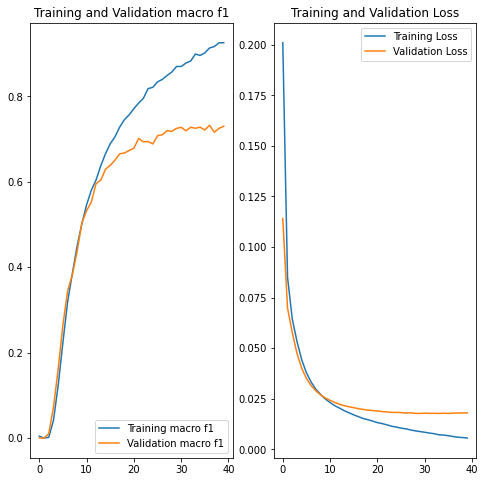

In [ ]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

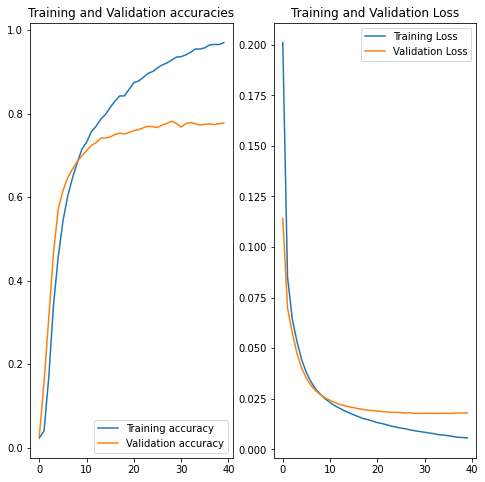

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history2 = model.fit(train_ds, epochs=50,batch_size = 20,
                            validation_data=create_dataset(X_val, y_val_bin))


['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0559/8c86998acba1428e84ef0c4d77885465.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0875/5a1e51000d944fecbbe9ca9894d2cf8e.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0769/a81f0265a1a048c5a3fa421f25b88bed.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0864/126201caa2534e6ea92d36b48d9ca529.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0363/0b5b203f56c340a0bae0f288d3c41672.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0700/56a8ad23355a47dca0ac0ba3b3ef5c56.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0938/f5a79fab8e0c407099d8b00d248ace67.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

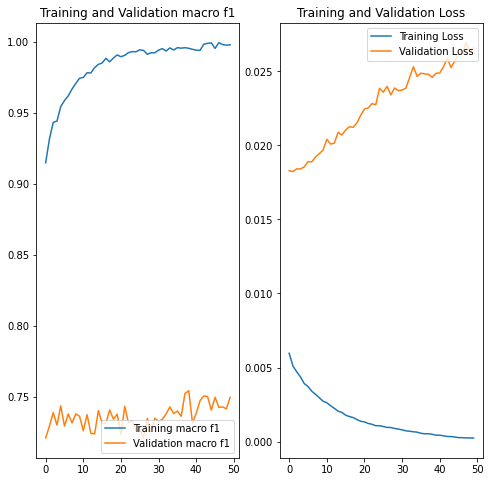

In [ ]:
macro_f1 = history.history['macro_f1']
val_macro_f1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, macro_f1, label='Training macro f1')
plt.plot(epochs_range, val_macro_f1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

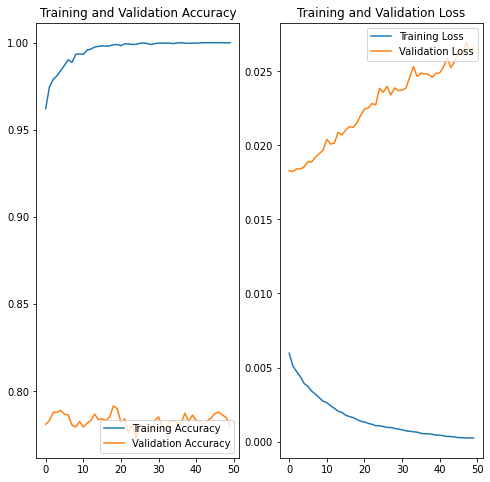

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()